### Bias correcting daily WRF precipitation using a probabilistic neural network  

Import required packages 

In [326]:
import numpy as np
import pandas as pd
import xarray as xr
import GPy
import geopandas
import geoplot
import random
import os
import shutil
import time
import scipy.stats as stats 

from IPython.display import clear_output

from math import pi
from datetime import datetime
from collections import OrderedDict

import torch
from torch.utils.data import TensorDataset, DataLoader 

from importlib import reload
from utils import *
from runmanager import *
from experiment import *
from plot_utils import plot_timeseries, print_summary_of_results

from shapely.geometry import box, mapping
import cartopy.crs as ccrs

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme()

Import required data

In [327]:
# Import dataframe
path = '..\..\PhD/data/pickle/df_stations_all_nonzero_extended.pkl'
st = pd.read_pickle(path)

# Replace NaN values from observed precipitation columns in observations Dataframe so that observed precipitation column can be read as float 

st['Prec'].replace(r'^\s*$', np.nan, regex=True, inplace=True)
st['Prec'].replace(r'.', np.nan, regex=True, inplace=True)
st.dropna(inplace=True)

start="1998-01-01"
end="2007-12-31"

print(len(st))
st = st[st['Date'].between(start,end)]
print(len(st))

364771
196997


In [328]:
st

,Date,Station,Prec,Corrected Station Name,X,Y,Altitude (m),Z,wrf_prcp,wrf_bc_prcp,elev_hr,aspect,slope,doy,doy_sin,doy_cos,wrf_prcp_-1,wrf_prcp_-2,wrf_prcp_1,wrf_prcp_2
6575,1998-01-01,Pandoh,0.0,Pandoh,-278888.1899,9.662201e+05,899.0,899.0,0.000000,0.000000,952.0,23.153692,3.394379,1,1.721336e-02,0.999852,0.000000,0.0,0.000000,0.000000
6576,1998-01-02,Pandoh,0.0,Pandoh,-278888.1899,9.662201e+05,899.0,899.0,0.000000,0.000000,952.0,23.153692,3.394379,2,3.442161e-02,0.999407,0.000000,0.0,0.000000,0.233845
6577,1998-01-03,Pandoh,0.0,Pandoh,-278888.1899,9.662201e+05,899.0,899.0,0.000000,0.000000,952.0,23.153692,3.394379,3,5.161967e-02,0.998667,0.000000,0.0,0.233845,0.000000
6578,1998-01-04,Pandoh,0.0,Pandoh,-278888.1899,9.662201e+05,899.0,899.0,0.233845,0.299024,952.0,23.153692,3.394379,4,6.880243e-02,0.997630,0.000000,0.0,0.000000,0.000000
6579,1998-01-05,Pandoh,0.0,Pandoh,-278888.1899,9.662201e+05,899.0,899.0,0.000000,0.000000,952.0,23.153692,3.394379,5,8.596480e-02,0.996298,0.233845,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364564,2007-12-27,Kaza,0.0,Kaza,-181865.3870,1.025750e+06,3639.0,3639.0,0.000000,0.000000,3645.0,214.276001,2.041792,361,-6.880243e-02,0.997630,0.000000,0.0,0.000000,0.000000
364565,2007-12-28,Kaza,0.0,Kaza,-181865.3870,1.025750e+06,3639.0,3639.0,0.000000,0.000000,3645.0,214.276001,2.041792,362,-5.161967e-02,0.998667,0.000000,0.0,0.000000,0.000000
364566,2007-12-29,Kaza,0.0,Kaza,-181865.3870,1.025750e+06,3639.0,3639.0,0.000000,0.000000,3645.0,214.276001,2.041792,363,-3.442161e-02,0.999407,0.000000,0.0,0.000000,0.000000
364567,2007-12-30,Kaza,0.0,Kaza,-181865.3870,1.025750e+06,3639.0,3639.0,0.000000,0.000000,3645.0,214.276001,2.041792,364,-1.721336e-02,0.999852,0.000000,0.0,0.000000,0.000000


In [329]:
st['BC_diff'] = st['wrf_prcp'] - st['wrf_bc_prcp']
aux = st.groupby('Station').sum()
aux.reset_index(inplace=True)
bc_stations = aux['Station'][aux['BC_diff']!=0].unique()

### Split training and test sets

K-fold train/validation split


In [330]:
# Select stations included in the analysis
only_bias_corrected = True

if only_bias_corrected:
    st_names = bc_stations
else:
    st_names = st['Station'].unique()

In [331]:
# Random selection of locations for train and test
np.random.shuffle(st_names)

split = round(len(st_names) * 0.2)

st_names_dict = {}
st_names_dict['train'] = list(st_names[:split*3])
st_names_dict['val'] = list(st_names[split*3:split*4])
st_names_dict['test'] = list(st_names[split*4:])

#st_names_train = list(st_names[:split*4])
#st_names_val = list(st_names[split*4:])
#st_names_test = list(set(list(st['Station'].unique())) - set(list(st_names)))

print("%s stations used for training, %s used for validation, and %s used testing" % (len(st_names_dict['train']), len(st_names_dict['val']), len(st_names_dict['test'])))

18 stations used for training, 6 used for validation, and 8 used testing


In [332]:
split_dict = {}

kf = KFold(n_splits=5,shuffle=True)
kf.get_n_splits(st_names)

for i, (train_index, val_index) in enumerate(kf.split(st_names)):
    split_dict[f'k{i}'] = {f'train': st_names[train_index],
                           f'val' : st_names[val_index]
                          }

### Prepare data

In [333]:
data = {}

predictors = ['wrf_prcp',
              'wrf_prcp_-2',
              'wrf_prcp_-1',
              'wrf_prcp_1',
              'wrf_prcp_2',
              'Z',
              'doy_sin',
              'doy_cos',
              #'X',
              #'Y',
              'aspect',
              'slope']

predictant = ['Prec']

X = st[predictors].to_numpy()

x_mean = X.mean(axis=0)
x_std = X.std(axis=0)
#x_min = X.min(axis=0)
#x_max = X.max(axis=0) 

for i in range(len(split_dict)):

    data[f'X_train_{i}'] = (st[st['Station'].isin(split_dict[f'k{i}']['train'])][predictors].to_numpy() - x_mean) / x_std
    data[f'X_val_{i}'] = (st[st['Station'].isin(split_dict[f'k{i}']['val'])][predictors].to_numpy() - x_mean) / x_std

    data[f'Y_train_{i}'] = st[st['Station'].isin(split_dict[f'k{i}']['train'])][predictant].to_numpy()
    data[f'Y_val_{i}'] = st[st['Station'].isin(split_dict[f'k{i}']['val'])][predictant].to_numpy()
    
data['X_test'] = (st[st['Station'].isin(st_names_dict['test'])][predictors].to_numpy() - x_mean) / x_std
data['Y_test'] = st[st['Station'].isin(st_names_dict['test'])][predictant].to_numpy()

### Train model with single run

In [368]:
d = len(predictors)

#r = np.random.randint(5)
#X_train, Y_train, X_val, Y_val, X_test, Y_test = data[f'X_train_{r}'], data[f'Y_train_{r}'], data[f'X_val_{r}'], data[f'Y_val_{r}'], data['X_test'], data['Y_test']

splits = ['train', 'val', 'test']
for i in splits:
    data[f'X_{i}'] = (st[st['Station'].isin(st_names_dict[f'{i}'])][predictors].to_numpy() - x_mean) / x_std
    data[f'Y_{i}'] = st[st['Station'].isin(st_names_dict[f'{i}'])][predictant].to_numpy()

train_tensor_x = torch.Tensor(data['X_train'][:,:d]) # transform to torch tensor
train_tensor_y = torch.Tensor(data['Y_train'][:,:d])
train_dataset = TensorDataset(train_tensor_x,train_tensor_y) # create your dataset

val_tensor_x = torch.Tensor(data['X_val'][:,:d]) # transform to torch tensor
val_tensor_y = torch.Tensor(data['Y_val'][:,:d])
val_dataset = TensorDataset(val_tensor_x,val_tensor_y) # create your dataset

test_tensor_x = torch.Tensor(data['X_test'][:,:d]) # transform to torch tensor
test_tensor_y = torch.Tensor(data['Y_test'][:,:d])
test_dataset = TensorDataset(test_tensor_x,test_tensor_y) # create your dataset

In [369]:
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

In [375]:
model = MLP(in_channels=d, 
            hidden_channels=[10], 
            likelihood_fn='b2gmm' # 'gamma', 'ggmm', bgmm', 'b2gmm', 'b2sgmm'
           )

print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')

Number of parameters: 176


In [376]:
mean_train_losses = []
mean_valid_losses = []

epochs = 30

optimizer = torch.optim.Adam(model.parameters(), lr=.001)

for epoch in range(epochs):
    train_losses, valid_losses = train_epoch(model, optimizer, train_loader, valid_loader, print_progress=True, epoch=epoch)
    
    mean_train_losses.append(np.mean(train_losses))
    mean_valid_losses.append(np.mean(valid_losses))

epoch : 1, train loss : 1.9661, valid loss : 1.5034
epoch : 2, train loss : 1.2530, valid loss : 1.3656
epoch : 3, train loss : 1.1881, valid loss : 1.3304
epoch : 4, train loss : 1.1660, valid loss : 1.3112
epoch : 5, train loss : 1.1539, valid loss : 1.2995
epoch : 6, train loss : 1.1450, valid loss : 1.2885
epoch : 7, train loss : 1.1380, valid loss : 1.2790
epoch : 8, train loss : 1.1332, valid loss : 1.2735
epoch : 9, train loss : 1.1293, valid loss : 1.2719
epoch : 10, train loss : 1.1272, valid loss : 1.2697
epoch : 11, train loss : 1.1253, valid loss : 1.2690
epoch : 12, train loss : 1.1235, valid loss : 1.2653
epoch : 13, train loss : 1.1222, valid loss : 1.2653
epoch : 14, train loss : 1.1212, valid loss : 1.2661
epoch : 15, train loss : 1.1200, valid loss : 1.2614
epoch : 16, train loss : 1.1191, valid loss : 1.2629
epoch : 17, train loss : 1.1183, valid loss : 1.2634
epoch : 18, train loss : 1.1173, valid loss : 1.2625
epoch : 19, train loss : 1.1165, valid loss : 1.2631
ep

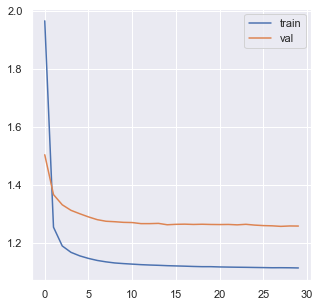

In [377]:
plt.figure(figsize=(5,5))
plt.plot(mean_train_losses)
plt.plot(mean_valid_losses)
plt.legend(["train","val"])
#plt.ylim([1,1.5])

### Histograms of predicted parameter values 

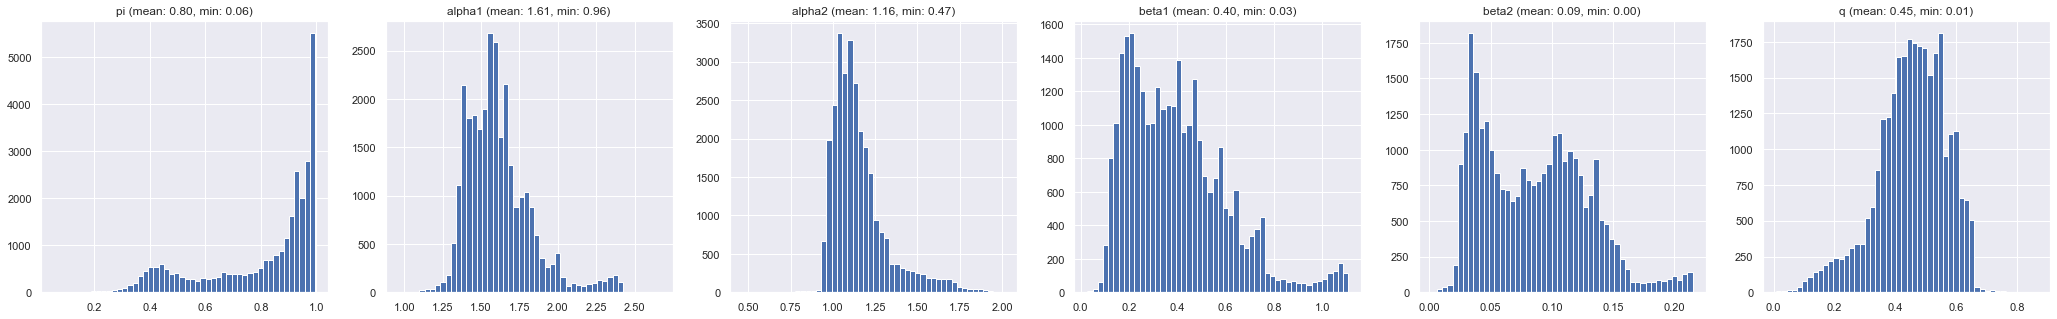

In [378]:
with torch.no_grad():
    inputs = test_dataset.tensors[0]
    outputs = model(inputs)
    
    n = outputs.shape[1]
    
    if model.likelihood=='gamma':
        variable = ['alpha', 'beta']
        
    elif model.likelihood=='ggmm': 
        variable = ['alpha1', 'alpha2', 'beta1', 'beta2', 'q']
        
    elif model.likelihood=='bgmm':
        variable = ['pi', 'alpha', 'beta']
        
    elif model.likelihood=='b2gmm': 
        variable = ['pi', 'alpha1', 'alpha2', 'beta1', 'beta2', 'q']
        
    elif model.likelihood=='b2sgmm': 
        variable = ['pi', 'alpha1', 'alpha2', 'beta1', 'beta2', 'q', 't']
        
    fig, ax = plt.subplots(1,n, figsize=(6*n, 5), sharex=False, sharey=False)
        
    for i in range(n):
        ax[i].hist(outputs[:,i].numpy(), bins=50)
        ax[i].title.set_text('%s (mean: %.2f, min: %.2f)' % (variable[i], 
                                                             outputs[:,i].mean(), 
                                                             outputs[:,i].min()))

tensor([0.9578, 1.6211, 1.1964, 0.4606, 0.1213, 0.3687])


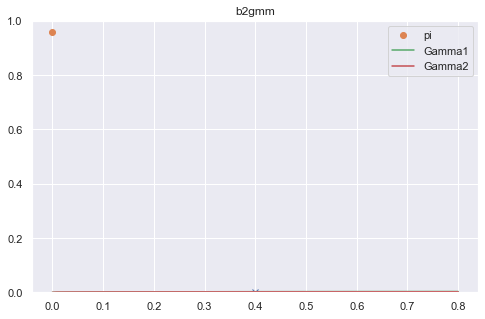

In [381]:
obs=0
while obs==0:
    r = np.random.randint(len(outputs))
    obs = test_tensor_y[r]
x = np.linspace (0, obs*2, 100) 

fig = plt.figure(figsize=(8,5))

plt.plot(obs,0,'x')

if model.likelihood=='gamma':
    alpha = outputs[r,0]
    beta = outputs[r,1]

if model.likelihood=='bgmm':
    pi = outputs[r,0]
    alpha = outputs[r,1]
    beta = outputs[r,2]

if model.likelihood=='ggmm':
    alpha1 = outputs[r,0]
    alpha2 = outputs[r,1]
    beta1 = outputs[r,2]
    beta2 = outputs[r,3]
    q = outputs[r,4]
    
if model.likelihood=='b2gmm':
    pi = outputs[r,0]
    alpha1 = outputs[r,1]
    alpha2 = outputs[r,2]
    beta1 = outputs[r,3]
    beta2 = outputs[r,4]
    q = outputs[r,5]

if model.likelihood=='b2sgmm':
    pi = outputs[r,0]
    alpha1 = outputs[r,1]
    alpha2 = outputs[r,2]
    beta1 = outputs[r,3]
    beta2 = outputs[r,4]
    q = outputs[r,5]
    t = outputs[r,6]

if model.likelihood=='gamma':
    y1 = stats.gamma.pdf(x, a=alpha, scale=1/beta)
    plt.plot(x, y1, label='Gamma')
    
if model.likelihood=='bgmm':
    plt.plot(0, pi, 'o', label='pi')
    y1 = stats.gamma.cdf(x, a=alpha, scale=1/beta)
    y1_med = stats.gamma.median(a=alpha, scale=1/beta)
    plt.plot(x, y1*(1-pi).numpy()+pi.numpy(), label='Gamma')
    plt.plot(y1_med, 0, 'o')

if model.likelihood=='ggmm':
    y1 = stats.gamma.pdf(x, a=alpha1, scale=1/beta1)
    plt.plot(x, y1*q.numpy(), label='Gamma1')
    y2 = stats.gamma.pdf(x, a=alpha2, scale=1/beta2)
    plt.plot(x, y2*(1-q).numpy(), label='Gamma2')

if model.likelihood=='b2gmm':
    plt.plot(0, pi, 'o', label='pi')
    y1 = stats.gamma.pdf(x, a=alpha1, scale=1/beta1)
    plt.plot(x, y1*(1-pi).numpy()*q.numpy(), label='Gamma1')
    y2 = stats.gamma.pdf(x, a=alpha2, scale=1/beta2)
    plt.plot(x, y2*(1-pi).numpy()*(1-q).numpy(), label='Gamma2')

if model.likelihood=='b2sgmm':
    plt.plot(0, pi, 'o', label='pi')
    plt.plot(t,0,'x', label='t')
    
plt.legend()
plt.title(model.likelihood)
plt.ylim(0,1)
print(outputs[r])
plt.show()

In [382]:
import plot_utils
import utils
reload(plot_utils)
reload(utils)
from plot_utils import *
from utils import *

In [383]:
with torch.no_grad():
    test_outputs = model(test_tensor_x)
    
st_test = build_results_df(st,
                           outputs=test_outputs,
                           st_names_test=st_names_dict['test'],
                           model=model,
                           p=0.05,
                           confidence_intervals=False)

print_summary_of_results(
                        st_test,
                        likelihood_fn=model.likelihood,
                        alldays=True,
                        drydays=True,
                        wetdays=True,
                        wet_threshold=0,
                        )

All Days ¦ Station : Larji ¦ WRF : 135.8 ¦ REG : 110.3 ¦ MLP : 118.4 ¦ Imp(REG) : 18.81% ¦ Imp(MLP) : 12.81% ¦ Imp(MLP_median) : 43.51% ¦ Imp(MLP_median_gamma) : 44.95%
Dry Days ¦ Station : Larji ¦ WRF : 32.7 ¦ REG : 25.9 ¦ MLP : 53.8 ¦ Imp(REG) : 20.83% ¦ Imp(MLP) : -64.23% ¦ Imp(MLP_median) : 95.27% ¦ Imp(MLP_median_gamma) : 49.19%
Wet Days ¦ Station : Larji ¦ WRF : 459.9 ¦ REG : 375.5 ¦ MLP : 321.7 ¦ Imp(REG) : 18.35% ¦ Imp(MLP) : 30.06% ¦ Imp(MLP_median) : 31.92% ¦ Imp(MLP_median_gamma) : 44.00%
-------------------------------------------------------------------------------
All Days ¦ Station : Janjehl ¦ WRF : 208.9 ¦ REG : 183.1 ¦ MLP : 222.1 ¦ Imp(REG) : 12.34% ¦ Imp(MLP) : -6.33% ¦ Imp(MLP_median) : 35.77% ¦ Imp(MLP_median_gamma) : 30.39%
Dry Days ¦ Station : Janjehl ¦ WRF : 39.2 ¦ REG : 31.9 ¦ MLP : 83.5 ¦ Imp(REG) : 18.64% ¦ Imp(MLP) : -113.03% ¦ Imp(MLP_median) : 78.66% ¦ Imp(MLP_median_gamma) : 16.98%
Wet Days ¦ Station : Janjehl ¦ WRF : 700.8 ¦ REG : 621.5 ¦ MLP : 624.0 ¦ I

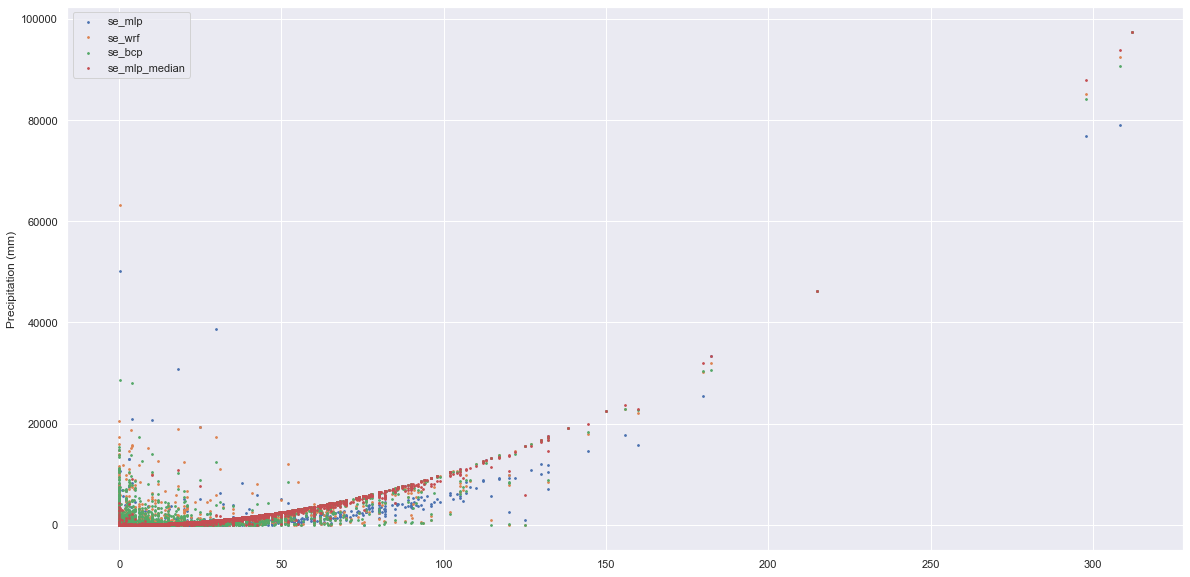

In [384]:
fig = plt.figure(figsize=(20,10))

columns = ['se_mlp','se_wrf','se_bcp','se_mlp_median']

for idx, ax in enumerate(axes.flatten()):
    x = st_test['Prec']
    y = st_test[columns[idx]]
    plt.scatter(x,y,label=columns[idx],s=3)
#plt.xlim(0,50)
#plt.ylim(0,100)
plt.ylabel('Squared error')
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.show()

In [385]:
def season(df,field='doy'):
    if (df[field]<53) or (df[field]>=53+92+91+92):
        return 'DJF'
    
    elif (df[field]>=53) and (df[field]<53+92):
        return 'MAM'
    
    elif (df[field]>=53+92) and (df[field]<53+92+91):
        return 'JJA'
    
    elif (df[field]>=53+92+91) and (df[field]<53+92+91+92):
        return 'SON'
    
st_test['season'] = st_test.apply(season, axis=1) 

In [386]:
st_test.describe()

,Prec,X,Y,Altitude (m),Z,wrf_prcp,wrf_bc_prcp,elev_hr,aspect,slope,doy,doy_sin,doy_cos,wrf_prcp_-1,wrf_prcp_-2,wrf_prcp_1,wrf_prcp_2,BC_diff,pi,alpha1,alpha2,beta1,beta2,q,occurrence,mean,median,median_gamma,se_wrf,se_bcp,se_mlp,e_wrf,e_bcp,e_mlp,se_mlp_median,se_mlp_median_gamma
count,28856.000000,28856.000000,2.885600e+04,28856.000000,28856.000000,28856.000000,28856.000000,28856.000000,28856.000000,28856.000000,28856.000000,28856.000000,28856.000000,28856.000000,28856.000000,28856.000000,28856.000000,28856.000000,28856.000000,28856.000000,28856.000000,28856.000000,28856.000000,28856.000000,28856.000000,28856.000000,28856.000000,28856.000000,28856.000000,28856.000000,28856.000000,28856.000000,28856.000000,28856.000000,28856.000000,28856.000000
mean,3.054855,-283494.710530,9.678478e+05,1317.573745,1317.573745,2.420470,2.856885,1344.032714,240.799814,2.414050,183.949716,-0.004136,0.000489,2.420532,2.421002,2.422675,2.422701,-0.436415,0.803172,1.612435,1.156212,0.398076,0.085479,0.453546,0.149570,3.494754,0.630042,2.076656,170.140599,170.986832,149.464883,-0.634385,-0.197970,0.439899,124.714473,119.825678
std,11.156430,46484.270621,3.003852e+04,994.301392,994.301392,9.638662,9.889873,979.522525,55.133183,1.337314,105.436362,0.706895,0.707331,9.638649,9.638619,9.641330,9.641324,2.677611,0.206583,0.212997,0.169668,0.206314,0.043263,0.114804,0.356656,9.495225,2.860292,5.727154,1403.153591,1331.851588,1228.573929,13.028585,13.074921,12.217878,1272.915026,1193.383174
min,0.000000,-331161.725200,9.182050e+05,557.000000,557.000000,0.000000,0.000000,557.000000,156.371582,0.284391,1.000000,-0.999991,-0.999963,0.000000,0.000000,0.000000,0.000000,-48.456390,0.055325,0.963461,0.468651,0.028051,0.002016,0.008128,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-312.000000,-312.000000,-312.000000,0.000000,0.000000
25%,0.000000,-321076.179100,9.453018e+05,657.000000,657.000000,0.000000,0.000000,764.000000,179.079453,1.656849,93.000000,-0.711657,-0.708627,0.000000,0.000000,0.000000,0.000000,0.000000,0.674446,1.464320,1.042481,0.230622,0.045830,0.387485,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-275545.001000,9.692102e+05,975.000000,975.000000,0.000000,0.000000,1023.000000,256.630890,2.164089,184.000000,-0.008607,0.004304,0.000000,0.000000,0.000000,0.000000,0.000000,0.903037,1.579565,1.113928,0.367776,0.083520,0.462895,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,-264117.274500,9.803277e+05,2071.000000,2071.000000,0.000000,0.000000,2053.000000,291.194336,3.672052,276.000000,0.705584,0.702527,0.000000,0.000000,0.000000,0.000000,0.000000,0.968298,1.704311,1.212744,0.512140,0.116649,0.537383,0.000000,0.000000,0.000000,0.000000,1.572626,3.598677,0.640000,0.000000,0.000000,0.000000,0.107034,0.360000
max,312.000000,-181865.387000,1.025750e+06,3639.000000,3639.000000,251.725098,171.184586,3645.000000,321.385223,4.693926,366.000000,0.999991,1.000000,251.725098,251.725098,251.725098,251.725098,82.217407,0.996009,2.662009,2.011300,1.106959,0.214781,0.866660,1.000000,226.557358,122.312263,143.593048,97344.000000,97344.000000,97344.000000,251.525098,169.307690,224.009030,97344.000000,97344.000000


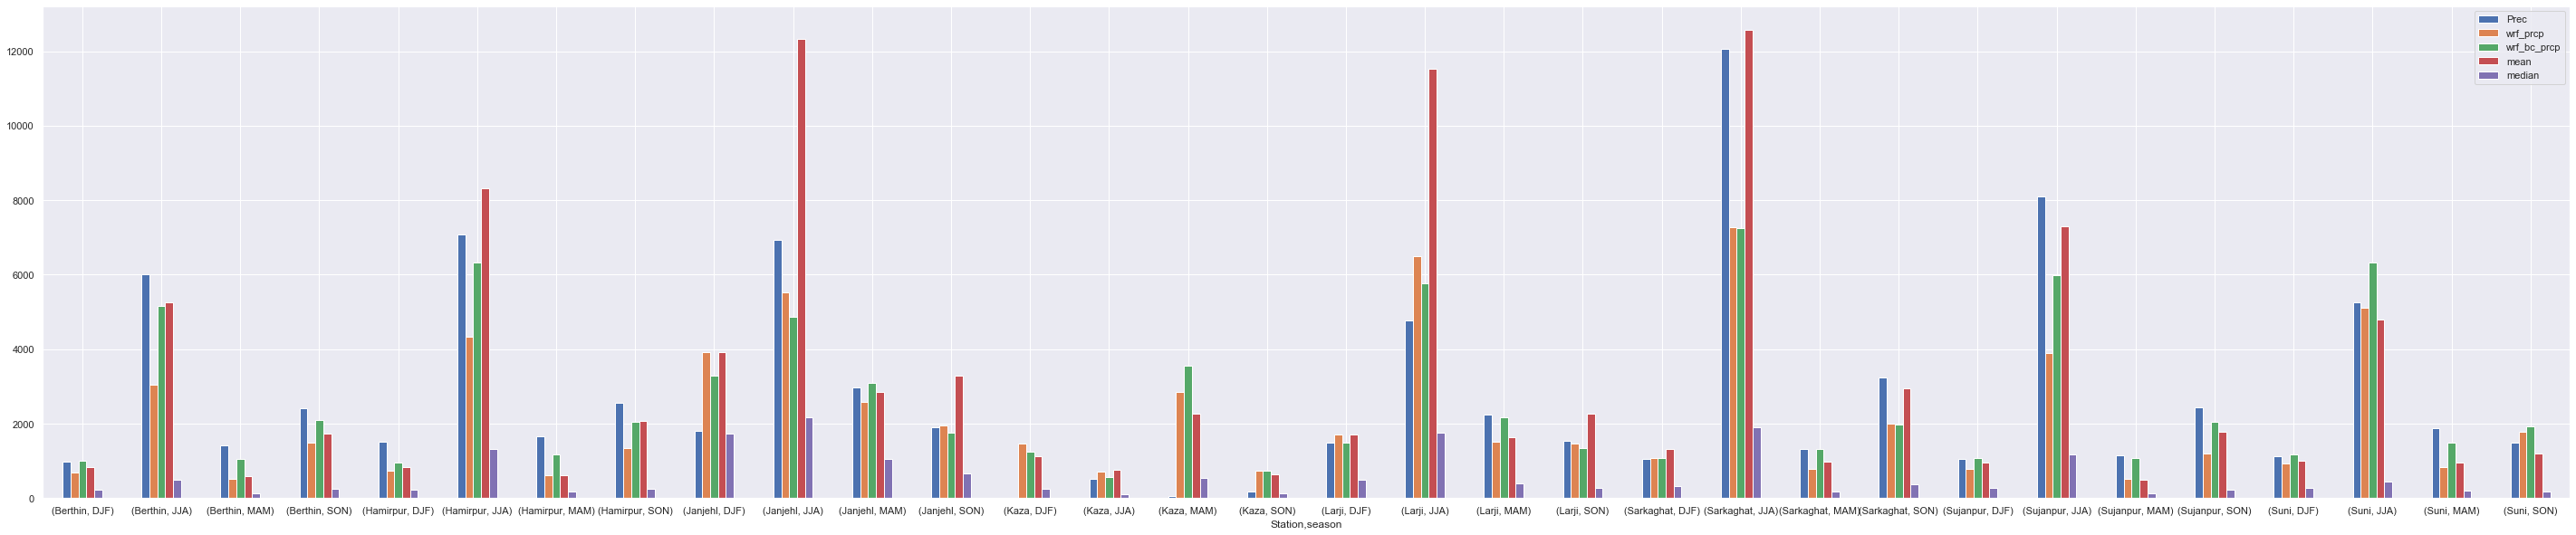

In [387]:
pd.options.display.max_columns = None
st_test_season_totals = st_test.groupby(['Station','season']).sum()
st_test_season_totals[['Prec','wrf_prcp','wrf_bc_prcp','mean','median']].plot.bar(rot=0, figsize=(50,10))
#st_test_season_totals[['Prec','mean']].unstack().plot(kind='bar')
plt.show()

In [388]:
columns = ['Prec','wrf_prcp','wrf_bc_prcp','mean','median','median_gamma']
seasons = ['DJF','MAM','JJA','SON']

In [389]:
import scipy
for col in columns:
    rvs = st_test[st_test['season']=='MAM']['Prec']
    cdf = st_test[st_test['season']=='MAM'][col]
    #kstest = scipy.stats.kstest(rvs, cdf, args=(), N=20, alternative='two-sided', mode='auto')
    kstest = scipy.stats.ks_2samp(rvs, cdf, alternative='two-sided', mode='auto')
    print(col, " : ", kstest.statistic)

Prec  :  0.0
wrf_prcp  :  0.05080066261733849
wrf_bc_prcp  :  0.053699613473219214
mean  :  0.07012700165654334
median  :  0.0717835450027609
median_gamma  :  0.07012700165654334


5
['Suni']


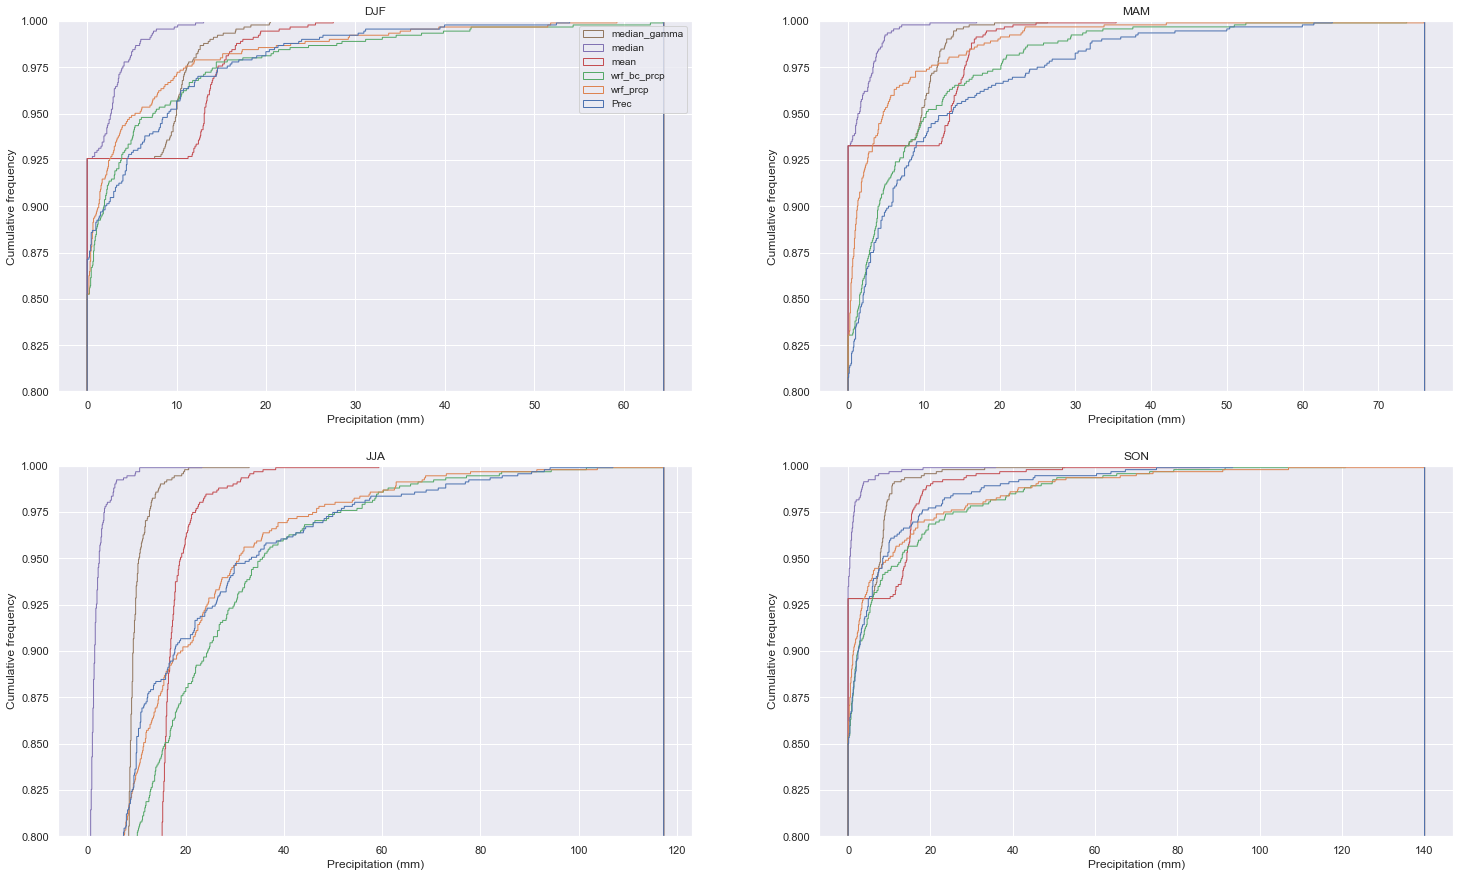

In [390]:
x_hist = st_test[st_test['season']=='DJF'][columns].to_numpy()
n_bins = 1000

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25,15))
ax0, ax1, ax2, ax3 = axes.flatten()

stations = st_test['Station'].unique()
random_station = np.random.randint(len(stations))
print(random_station)
st_test_station = st_test[st_test['Station']==stations[random_station]]
print(st_test_station['Station'].unique())

for idx, ax in enumerate(axes.flatten()):
    x_hist = st_test_station[st_test_station['season']==seasons[idx]][columns].to_numpy()
    ax.hist(x_hist, n_bins, density=True, cumulative=True, histtype='step', label=columns)
    ax.set_ylim([0.8,1])
    #ax.set_xlim([0,100])
    ax.set_xlabel('Precipitation (mm)')
    ax.set_ylabel('Cumulative frequency')
    if idx==0:
        ax.legend(prop={'size': 10})
    ax.set_title(seasons[idx])

### Train model with different hyperparameters

In [391]:
params = OrderedDict(
    lr = [.01]
    ,batch_size = [128]
    ,likelihood_fn = ['bgmm', 'b2gmm']
    ,hidden_channels = [10]
    #,k = [0]
    ,k = [0,1,2,3,4]
)

epochs = 5

In [392]:
m = RunManager()
predictions={}
for l in params['likelihood_fn']:
    predictions[l] = {} 

for run in RunBuilder.get_runs(params):
    
    d=6
    
    network = MLP(in_channels=d, 
            hidden_channels=run.hidden_channels, 
            likelihood_fn=run.likelihood_fn
            )
    
    train_tensor_x = torch.Tensor(data[f'X_train_{run.k}'][:,:d]) # transform to torch tensor
    train_tensor_y = torch.Tensor(data[f'Y_train_{run.k}'][:,:d]) # transform to torch tensor
    train_dataset = TensorDataset(train_tensor_x,train_tensor_y) # create training dataset

    val_tensor_x = torch.Tensor(data[f'X_val_{run.k}'][:,:d]) # transform to torch tensor
    val_tensor_y = torch.Tensor(data[f'Y_val_{run.k}'][:,:d]) # transform to torch tensor
    val_dataset = TensorDataset(val_tensor_x,val_tensor_y) # create test dataset
    
    test_tensor_x = torch.Tensor(data['X_test'][:,:d]) # transform to torch tensor
    test_tensor_y = torch.Tensor(data['Y_test'][:,:d]) # transform to torch tensor
    test_dataset = TensorDataset(test_tensor_x,test_tensor_y) # create test dataset
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=run.batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=run.batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=run.batch_size, shuffle=False)
    
    optimizer = torch.optim.Adam(network.parameters(), lr=run.lr)
    
    change_folder = True
    if change_folder:
        experiment_name = f'{run}'
        wd = WorkingDirectory(generate_root(experiment_name))
    
    m.begin_run(run, network, train_loader)
    
    train_losses = []
    val_losses = []
    
    for epoch in range (epochs):
        
        m.begin_epoch()
        
        train_loss, val_loss = train_epoch(network, 
                                             optimizer, 
                                             train_loader, 
                                             val_loader, 
                                             epoch=epoch, 
                                             print_progress=False)

        m.epoch_loss = train_loss
        m.epoch_val_loss = val_loss
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
            
        m.end_epoch()
        
        save_as_best = True if val_loss == min(val_losses) else False
        save_checkpoint(wd,network.state_dict(),is_best=save_as_best)
    
        PATH = os.path.join(wd.root,'e_%s_loss_%.3f.pth.tar' % (epoch, val_loss))
        torch.save(network.state_dict(), PATH)
        
    load_best = True
    if load_best:
        network.load_state_dict(torch.load(os.path.join(wd.root,'model_best.pth.tar')))
        
    with torch.no_grad():
        outputs = network(val_tensor_x)
    
    st_test = build_results_df(st, 
              outputs, 
              #st_names_test=st_names_test,                 
              st_names_test=split_dict[f'k{run.k}']['val'], 
              model=network)
    
    predictions[run.likelihood_fn][f'k{run.k}'] = st_test
    
    SAVEPATH = os.path.join(wd.root, "st_test.pkl")
    st_test.to_pickle(SAVEPATH)
    
    m.end_run()    
    
m.save('results')     

TypeError: 'int' object is not subscriptable

In [ ]:
for k in predictions.keys():
    for i in range(len(params['k'])):
        predictions[k][f'k{i}']['k_fold'] = i
        if i == 0:
            predictions[k]['k_all'] = predictions[k][f'k{i}']
        else:
            predictions[k]['k_all'] = predictions[k]['k_all'].append(predictions[k][f'k{i}'])

In [ ]:
df = pd.read_csv('results.csv', index_col='Unnamed: 0')
df.sort_values('valid_loss')

In [ ]:
plt.figure(figsize=(30,10))

linecolors = {"0" : "black",
              "1" : "blue",
              "2" : "green",
              "3" : "orange",
              "4" : "red"}

linestyles = {"bgmm" : "solid",
             "b2gmm" : "dashed"}

markerstyles = {"10" : "o",
                "100" : "x"}

style_dict = {"linestyles" : linestyles,
             "linecolors" : linecolors}

for a in df.likelihood_fn.unique():
    for b in df.k.unique():
        for d in df.hidden_channels.unique(): 
            c = df[(df.likelihood_fn == a) & (df.k == b) & (df.hidden_channels == d)].copy()
            plt.plot(c.epoch, 
                     c.valid_loss, 
                     label=f'{a}_k{b}_h{d}', 
                     linestyle=linestyles[a],
                     color = linecolors[str(b)],
                     marker = markerstyles[str(d)],
                     linewidth = 1,
                     markersize = 5
                    )

plt.legend(loc='upper left')
plt.xlim([0,20])
plt.xlabel('epoch')
plt.ylabel('loss (-loglik)')
plt.show()

### Sample from 2-Gamma mixture model and plot

In [ ]:
%%time
k = 1
bins = 1000
hist_max = 50
r = np.random.randint(outputs.shape[0], size=k)
print(r)
dist = gmm_fn(pi=outputs[r,0],
            alpha1=outputs[r,1],
            alpha2=outputs[r,2],
            beta1=outputs[r,3],
            beta2=outputs[r,4],
            q=outputs[r,5],
            )

plt.figure(figsize=(15,5))
plt.plot(np.linspace(0,hist_max,bins),(torch.histc(dist.sample([1000000]), bins=bins, min=0, max=hist_max)))
plt.plot(dist.mean,np.zeros(k),'or')
plt.plot(test_tensor_y[r],np.zeros(k),'xk',ms=10)
plt.show()

### Sample from Bernoulli-Gamma mixture model

In [ ]:
interval=5

flag = 0
if flag:

    while True:

        x = np.linspace (0, 100, 200) 
        r = np.random.randint(len(inputs))
        print(r)

        pi = outputs[r,0]
        a = outputs[r,1]
        rate = outputs[r,2]

        y1 = stats.gamma.cdf(x, a=a, scale=1/rate) #a is alpha, loc is beta???

        mu = stats.gamma.mean(a=a, scale=1/rate)
        median = stats.gamma.median(a=a, scale=1/rate)
        mixture_median = stats.gamma.ppf((0.5 - pi) / (1 - pi), a=a, scale=1/rate) if pi < 0.5 else 0
        mixture_mean = (1-pi) * mu

        print("mean: %.2f" % mu)
        print("median: %.2f" % median)
        print("mixture median: %.2f" % mixture_median)
        print("mixture mean: %.2f" % mixture_mean)

        modelled = inputs[r,0]*x_std[0] + x_mean[0]
        observed = tensor_y[r,0]

        if modelled > 0:

            #mu = a/rate if pi<0.5 else 0

            plt.plot(0,pi,"oy", label="pi = %.2f" % pi)

            plt.plot(mu, 0, "or", mfc="white", label="mu = %.2f" % mu)
            plt.plot(median, 0, "xr", label="median = %.2f" % median)  
            plt.plot(mixture_median, 0, "ok", mfc="white", label="mixture median = %.2f" % mixture_median)  
            plt.plot(mixture_mean, 0, "^k", label="mixture median = %.2f" % mixture_mean)  

            plt.plot(modelled, 0, "x", label="WRF = %.2f" % modelled)

            plt.plot(observed, 0, "xg", label="observed = %.2f" % observed)
            plt.plot(x, pi + (1-pi)*y1, "y-", label=(r'$\alpha=%.2f, \beta=%.2f$') % (a, rate))

            plt.ylim([-0.05,1])
            plt.xlim([-0.2, max([1,modelled,observed,mu])*1.20])
            plt.legend(loc="upper right")
            plt.show()

            time.sleep(interval)

        else:
            pass

        clear_output(wait=True)

### Plot time series of predictions

In [393]:
p=0.05
multirun=0

if multirun:
    likelihood_fn = 'b2gmm'
    st_test = predictions[likelihood_fn]['k_all']
else:
    likelihood_fn = model.likelihood

In [394]:
import utils, plot_utils
reload(utils)
reload(plot_utils)
from utils import *
from plot_utils import *

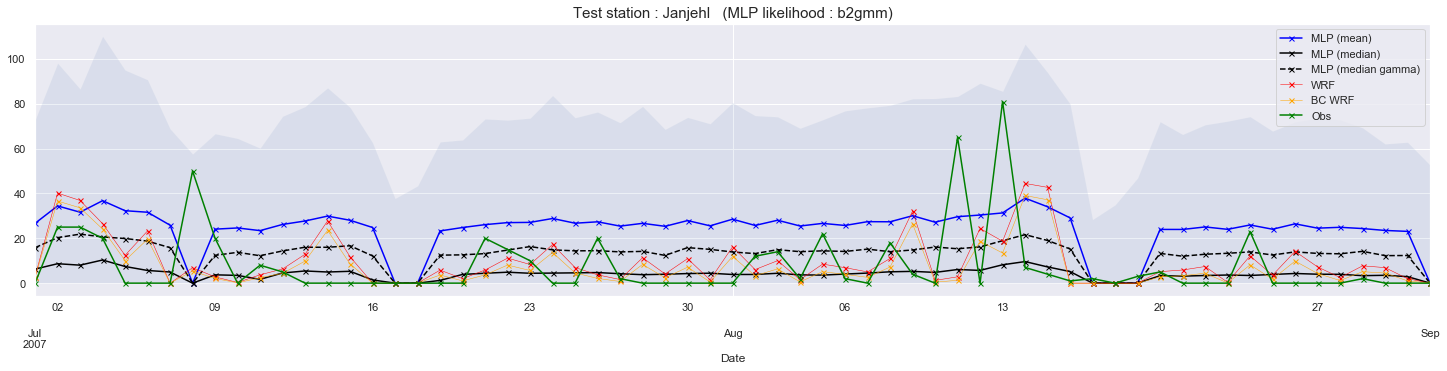

In [396]:
st_names_test = st_test['Station'].unique()

r = np.random.randint(len(st_names_test))
rand_test_st = st_names_test[r]
st_test_r = st_test[st_test['Station']==rand_test_st].copy()

xmin = "2007-07-01"
xmax = "2007-09-01" 

plot_timeseries(st_test_r, 
                likelihood_fn,
                figsize=(25,5),
                xmin = xmin,
                xmax = xmax
               )

#plt.savefig(f"exports/tiemseries_{rand_test_st}_{xmin}_{xmax}.png")

### Print summary of results

In [ ]:
print_summary_of_results(st_test, likelihood_fn, alldays=True, drydays=True, wetdays=True, wet_threshold=50)

In [ ]:
day_filter = 'alldays'
p_threshold = 50

if day_filter=='drydays':
    st_test_summary = st_test[st_test['Prec']==0].groupby('Station').mean()
elif day_filter=='wetdays':
    st_test_summary = st_test[st_test['Prec']>=p_threshold].groupby('Station').mean()
elif day_filter=='alldays':
    st_test_summary = st_test.groupby('Station').mean()

st_test_summary.drop(columns=['Altitude (m)', 'Prec', 'model_precipitation', 'doy', 'doy_cos', 'doy_sin'], inplace=True)

st_test_summary['se_mlp_ratio'] = 1 - st_test_summary['se_mlp']/st_test_summary['se_wrf']
st_test_summary['se_mlp_median_ratio'] = 1 - st_test_summary['se_mlp_median']/st_test_summary['se_wrf']
st_test_summary['se_mlp_median_gamma_ratio'] = 1 - st_test_summary['se_mlp_median_gamma']/st_test_summary['se_wrf']
st_test_summary['se_reg_ratio'] = 1 - st_test_summary['se_bcp']/st_test_summary['se_wrf']

In [ ]:
plt.figure(figsize=(8,8))
plt.style.use('seaborn-dark-palette')
plt.plot(st_test_summary['Z'],st_test_summary['se_mlp_ratio'],'og', label='$\mu$ - Neural Network (Bernoully Gamma mixture model)')
plt.plot(st_test_summary['Z'],st_test_summary['se_mlp_median_ratio'],'xb', label='$median$ - Neural Network (Bernoully Gamma mixture model)')
plt.plot(st_test_summary['Z'],st_test_summary['se_mlp_median_gamma_ratio'],'>k', label='$median$ $\Gamma$ - Neural Network (Bernoully Gamma mixture model)')

plt.plot(st_test_summary['Z'],st_test_summary['se_reg_ratio'],'or', label='Bannister et al. (2019)')

plt.xlabel("Elevation (masl)")
plt.ylabel("MSE reduction ratio")
plt.ylim([-1, 1])
plt.legend()
plt.savefig(f"exports/MSE_plot_{day_filter}.png")
plt.show()

In [ ]:
"""plt.figure(figsize=(10,10))

plt.plot(st_test_r['Prec'], st_test_r['se_mlp'],'o',ms=4,label="MLP")
plt.plot(st_test_r['Prec'], st_test_r['se_wrf'],'x',ms=4,label="WRF")

plt.legend()

#plt.ylim([-0,20000])
plt.show()""";

In [ ]:
path = '..\..\PhD/gis/exports/beas_watershed.shp'
beas_watershed = geopandas.read_file(path)

path = '..\..\PhD/gis/exports/sutlej_watershed.shp'
sutlej_watershed = geopandas.read_file(path)

In [ ]:
stations_df_train = st[st['Station'].isin(st_names_dict['train'])].groupby(['Station']).mean()
stations_df_train = stations_df_train[['X','Y']]

stations_df_val = st[st['Station'].isin(st_names_dict['val'])].groupby(['Station']).mean()
stations_df_val = stations_df_val[['X','Y']]

gdf = build_geodataframe(st_test_summary, x='X', y='Y')

gdf_train = build_geodataframe(stations_df_train, x='X', y='Y')
gdf_val = build_geodataframe(stations_df_val, x='X', y='Y')

In [ ]:
"""fig, axes = plt.subplots(1, 2, figsize=(15,10), constrained_layout=True)
#color_map = plt.cm.get_cmap('seismic').reversed()
margin = 0.25

for i, ax in enumerate(axes):
    gdf.plot(ax=ax, column='k_fold', legend=True, cmap='Set1', markersize=20, marker="o", linewidth=3)
    beas_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=0.5)
    sutlej_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=0.5)
    #if i==len(axes)-1:
    #    plt.colorbar(plt.cm.ScalarMappable(cmap='Set1'), ax=ax, shrink=0.6)
    #ax.set_xlim(gdf.X.min() - margin*(gdf.X.max() - gdf.X.min()), gdf.X.max() + margin*(gdf.X.max() - gdf.X.min()))
    #ax.set_ylim(gdf.Y.min() - margin*(gdf.Y.max() - gdf.Y.min()), gdf.Y.max() + margin*(gdf.Y.max() - gdf.Y.min()))
    #ax.set_ylabel(" ")
    #ax.set_xlabel(" ")
    ax.set_axis_off()
    ax.set_aspect(1)

#axes[0].scatter(gdf.X, gdf.Y, c=gdf.se_mlp_ratio, cmap=color_map)
#gdf.plot(ax=axes[0], column='se_mlp_ratio',legend=True, edgecolor = 'white',  cmap=color_map,  markersize=100, vmin=-1, vmax=1)
axes[0].set_title('MLP', fontsize=16)
#gdf.plot(ax=axes[1], column='se_reg_ratio',legend=True, edgecolor = 'white', cmap=color_map,  markersize=100, vmin=-1, vmax=1)
#axes[1].set_title('Bannister et al. (2019)', fontsize=16)

#plt.legend()
#plt.tight_layout()
plt.show()

#plt.savefig(likelihood_fn+'.png')""";

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import numpy as np
plt.style.use('seaborn-dark-palette')

title = ['$\mu$ Neural Network', '$median$ Neural Network', '$median$ $\Gamma$ Neural Network', 'Bannister et al. (2019)']
var = ['se_mlp_ratio', 'se_mlp_median_ratio', 'se_mlp_median_gamma_ratio', 'se_reg_ratio']

fig = plt.figure(figsize=(20, 20))

color_map = plt.cm.get_cmap('seismic').reversed()

grid = AxesGrid(fig, 111,
                nrows_ncols=(2, 2),
                #aspect=False,
                axes_pad=0,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.05,
                cbar_size="2.5%"
                )

for i, ax in enumerate(grid):
    ax.set_axis_off()
    ax.set_yticks([])
    ax.set_xticks([])
    
    #ax.set_xlim(gdf.X.min() - margin*(gdf.X.max() - gdf.X.min()), gdf.X.max() + margin*(gdf.X.max() - gdf.X.min()))
    #ax.set_ylim(gdf.Y.min() - margin*(gdf.Y.max() - gdf.Y.min()), gdf.Y.max() + margin*(gdf.Y.max() - gdf.Y.min()))
    
    beas_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=0.5)
    sutlej_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=0.5)
    
    if i==0:
        gdf_train.plot(ax=ax, markersize=15, color='green')
        gdf_val.plot(ax=ax, markersize=15, color='orange')
    
    sc = ax.scatter(gdf.X, gdf.Y, c=gdf[var[i]], s=100, marker='p', cmap=color_map, vmin=-1, vmax=1, edgecolor='k')
    ax.set_title(title[i], fontsize=15)
    
# when cbar_mode is 'single', for ax in grid, ax.cax = grid.cbar_axes[0]
cbar = grid.cbar_axes[0].colorbar(sc)
cbar.ax.set_yticks([-1,0,1])
cbar.ax.tick_params(labelsize=15)
plt.savefig(f'exports/{likelihood_fn}_{np.random.randint(1000)}.png')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
gdf.plot(ax=ax, column='k_fold', legend=False, cmap='Set1', markersize=20, marker="o", linewidth=3)
beas_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=0.5)
sutlej_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=0.5)
ax.set_axis_off()
plt.savefig(f'exports/k_fold_{likelihood_fn}_{np.random.randint(1000)}.png')
plt.show()